# **Chapter 3: Learned Embeddings**

So far you've just been re-implementing ideas described in a manuscript. We'd like to keep from re-implementing everything. How does this work with our embedding problem?  The real win would be if I could call some function with a list of peptides and it would return to me the embedded tensor. Wouldn't that be awesome?

This is what we call 'borrowing' the embedding. In Chapter 1, the three methods of embedding were trivial. It is unlikely that there are packages available for them. In Chapter 2, the fourth method (atomic embedding) is complex enough that a package would be best.

In this chapter, we will demonstrate how to *borrow* embeddings, and also go over a *learned embedding*.

## **Using this Tutorial**

This tutorial is designed to be interactive, and you are encouraged to change the code and explore. To do this, you'll need to save a copy of this so that you have editing permissions. Use `File->Save a copy in Drive` to make an editable copy for yourself. Colab notebooks consist of text cells (like this one) and code cells. You interact with the notebook by executing (running) the code cells by clicking the "play button" in each cell. You can also run all cells at once by using `Runtime->Run all`.

## Level 5: Learned Embeddings
The embeddings in chapters 1 and 2, are **derived directly from human ideas**. We created the one-hot encoding (method 3) following the exact instructions someone designed. Also, the more complex tensor in method 4 was derived from our ideas about chemistry, e.g. a layer that is bi-amino acid frequency. All of these embeddings are designed after our ideas. In machine learning, we say these are *hand crafted*.

One of the big advancements in ML in recent years has been to **have the program learn an embedding**. We don't explicitly design how to embed. The machine learning itself determines a meaningful representation. We just give it a big space (like a giant tensor), and allow it to fill that space according to it's learning objective.

If you are new to neural networks, this could be a bit unsettling. We don't know what the embeddings mean; we just know that they were useful towards some learning/prediction goal. Hopefully, you are asking 'useful towards what?'. That's an important question. There are many different learned embeddings, and each one has been trained towards a different purpose. So you should borrow an embedding if you think that the goals of the original training are applicable towards you problem.

In this chapter, we'll discuss one popular and useful embedding - the Evolutionary Scale Modeling or ESM. We'll go over the conceptual purpose of the embedding and also the code for how to borrow it. There are other embeddings that you may find out there on the interwebs. For each one, you'll want to read about its purpose and see if it aligns with yours.

## Modeling Evolution
Modern DNA sequencing has revealed the genomes of millions organisms. We can compare related protein sequences from very distantly related organisms. For example, we could compare the ribosome proteins from a human to ribosome proteins in a maple tree, or in a bacterium. These related proteins serve the same function, but their sequences have changed over time. With millions of genomes, scientists have tried to better understand the evolutionary process, in efforts to model sequence divergence. For many years, people worked to identify families of proteins across different organisms and categorize the flexible and inflexible parts of the protein (e.g. [PFam](https://en.wikipedia.org/wiki/Pfam)). If you want to learn more about this data science investigation, look into topics like [molecular evolution](https://en.wikipedia.org/wiki/Molecular_evolution) and [sequence homology](https://en.wikipedia.org/wiki/Sequence_homology). This is a vast and interestig part of bioinformatics.

Important gains in computer hardward and software in the 2010s have made Deep Neural Networks a popular method for machine learning. This timeframe co-incided with the huge data generation from genomics. So now scientists are using Deep Learning to model protein evolution - What is acceptable neutral drift? What would be positive selection for increased fitness? what would be a deleterious mutation?

EMS is an evolutionary model, including protein sequence, structure and function (see the [ESM Science paper](https://www.science.org/doi/10.1126/science.ads0018).) As a model, it is trained using a masking technique, where part of the sequence is removed and the model is asked to predict that hidden/masked sequence. It's actually much more complicated than that, but this is a reasonable simplification. This training helps scientists understand things like - what is an acceptable sequence for a specific protein function.

To train their model, they had to transform the protein sequence into some numeric representation. Unlike our previous chapters where the representation was hand crafted, this was not. The internal representation of sequences was created during the training. The embedding was *learned*. And is now something that we can now utilize (i.e. borrow).

## Borrowing the ESM model for mass spectrometry

In proteomics, we can benefit from this protein modeling ML. Even though ESM is a neural net to model protein evolution, it still has figured out some important things about amino acid properties. It could be a really good place to start if one were going to do proteomics machine learning of peptide sequences.

In the tutorial below, we demonstrate how to borrow the embeddings from the ESM model. We give it our peptide sequence, and it gives us back a tensor.

In [ ]:
# @title Interactive Tutorial
%%html
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Interactive GitHub Tutorial</title>
  <style>
    /* Base Styles */
    body {
      font-family: Arial, sans-serif;
      background: #f0f0f0;
      margin: 0;
      padding: 0;
    }
    .tutorial-wrapper {
      max-width: 800px;
      margin: 40px 0 40px 40px;
      background: #fff;
      box-shadow: 0 4px 12px rgba(0,0,0,0.1);
      overflow: hidden;
      border-radius: 8px;
    }
    /* Slides Container: using flex to line up slides side-by-side */
    .slides-container {
      display: flex;
      transition: transform 0.5s ease-in-out;
      width: 500%; /* 5 slides x 100% each */
    }
    .slide {
      width: 100%;
      flex-shrink: 0;
      padding: 40px;
      box-sizing: border-box;
    }
    .slide h1 {
      margin-top: 0;
      color: #333;
    }
    .slide p {
      font-size: 18px;
      line-height: 1.6;
      color: #666;
    }
    /* Navigation Buttons */
    .nav-buttons {
      text-align: center;
      padding: 20px;
      background: #fafafa;
      border-top: 1px solid #eee;
    }
    .nav-buttons button {
      padding: 10px 20px;
      margin: 0 10px;
      font-size: 16px;
      border: none;
      border-radius: 4px;
      cursor: pointer;
    }
    .nav-buttons button:disabled {
      background: #ddd;
      cursor: not-allowed;
    }
    .nav-buttons button:not(:disabled) {
      background: #4285F4;
      color: white;
    }
    /* Link Styled as a Button */
    a.button-link {
      display: inline-block;
      padding: 10px 20px;
      background: #34A853;
      color: white;
      text-decoration: none;
      border-radius: 4px;
      margin-top: 20px;
    }
    /* Code Cell Styling */
    .code-cell {
      display: none;
      margin-top: 20px;
      background: #e8e8e8;
      border: 1px solid #ccc;
      padding: 10px;
      font-family: monospace;
      white-space: pre-wrap;
    }
  </style>
</head>
<body>
  <div class="tutorial-wrapper">
    <!-- Slides container for the interactive tutorial -->
    <div id="slides" class="slides-container">
      <!-- Slide 1: Welcome -->
      <div class="slide">
        <h1>ESM Tutorial</h1>
        <p>This interactive tutorial will give a basic understanding of how to use Facebook's</p>
        <p><strong>Evolutionary Scale Modeling (ESM)</strong> model to embed your protein sequences.</p>
        <p>Use the code cell below to follow along with the tutorial.</p>
      </div>
      <!-- Slide 2: Visit the Repository -->
      <div class="slide">
        <h1>Step 1: Visit the Repository</h1>
        <p>Head over to the GitHub page for <strong>facebookresearch/esm</strong>.</p>
        <p>Briefly browse the repository to see details about the project.</p>
        <p><a class="button-link" href="https://github.com/facebookresearch/esm" target="_blank">Open Repository</a></p>
      </div>
      <!-- Slide 3: Install the package -->
      <div class="slide">
        <h1>Step 2: Install the Package</h1>
        <p>In the repository, under <strong>"Getting started with this repo"</strong> Find the one-liner that installs </p>
        <p>the <strong>latest release of ESM</strong> onto your Colab and paste it in the cell below.</p>
        <p>(Note: make sure to put a `!` in front of the command for the Colab cell.)</p>
        <button id="helpBtn">Click for help</button>
        <div id="codeCell" class="code-cell">
!pip install fair-esm
        </div>
      </div>
    <!-- Slide 4: Paste the Quickstart -->
      <div class="slide">
        <h1>Step 2: Paste in the Quickstart instructions</h1>
        <p>Find the code cell located after the text: </p>
        <p><strong>"After pip install, you can load and use a pretrained model as follows:"</strong></p>
        <p>Paste the code in the cell below (after the install command).</p>
        <p>Run the cell.</p>
    </div>

      <!-- Slide 5: Congratulations -->
      <!-- <div class="slide">
        <h1>Congratulations!</h1>
        <p>You have completed the tutorial. Use the navigation buttons to review previous steps or explore the repository further.</p>
      </div> -->
    </div>
    <!-- Navigation Buttons -->
    <div class="nav-buttons">
      <button id="prevBtn" disabled>Previous</button>
      <button id="nextBtn">Next</button>
    </div>
  </div>

  <script>
    // JavaScript to handle slide transitions
    const slidesContainer = document.getElementById('slides');
    const prevBtn = document.getElementById('prevBtn');
    const nextBtn = document.getElementById('nextBtn');
    const totalSlides = document.querySelectorAll('.slide').length;
    let currentSlide = 0;

    function updateSlidePosition() {
      slidesContainer.style.transform = 'translateX(-' + (currentSlide * 100) + '%)';
      prevBtn.disabled = currentSlide === 0;
      nextBtn.disabled = currentSlide === totalSlides - 1;
    }

    prevBtn.addEventListener('click', () => {
      if (currentSlide > 0) {
        currentSlide--;
        updateSlidePosition();
      }
    });

    nextBtn.addEventListener('click', () => {
      if (currentSlide < totalSlides - 1) {
        currentSlide++;
        updateSlidePosition();
      }
    });

    // Enable keyboard navigation with arrow keys
    document.addEventListener('keydown', (event) => {
      if (event.key === 'ArrowRight' && currentSlide < totalSlides - 1) {
        currentSlide++;
        updateSlidePosition();
      } else if (event.key === 'ArrowLeft' && currentSlide > 0) {
        currentSlide--;
        updateSlidePosition();
      }
    });

    // Toggle the code cell display when the help button is clicked
    document.getElementById('helpBtn').addEventListener('click', function () {
      const codeCell = document.getElementById('codeCell');
      if (codeCell.style.display === 'none' || codeCell.style.display === '') {
        codeCell.style.display = 'block';
      } else {
        codeCell.style.display = 'none';
      }
    });
  </script>
</body>
</html>


In [ ]:
# Paste your code from the tutorial in this cell.
!pip install fair-esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
# @title  We can then rewrite the above github code as a function where we can pass in our peptides

import torch
try: import esm
except:
  !pip install fair-esm
  import esm
def get_embeddings(data):
    # Load ESM-2 model
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()  # disables dropout for deterministic results

    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

    # Look at the unsupervised self-attention map contact predictions
    import matplotlib.pyplot as plt
    for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
        plt.matshow(attention_contacts[: tokens_len, : tokens_len])
        plt.title(seq)
        plt.show()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


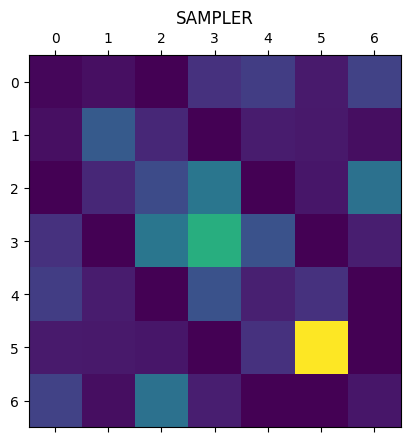

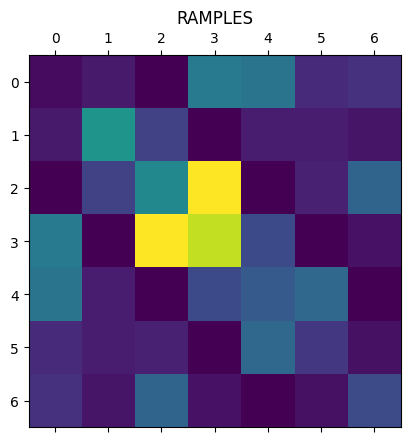

In [ ]:
# Sample of peptide sequences (from Chapter 1)
peptide_seqs = [
#   "CGDILGVTSK",
#   "SKVPAFVR",
#   "ISEIEDAAFLAR",
#   "DCGEWAIPGGMVDPGEK",
#   "EVPVPTPAPVEVPVPER",
#   "TLPADVQNYYSR",
#   "LNVTEQEKIDKLMIEMDGTENK",
#   "THSQGGYGSQGYKYNWK",
#   "SHWAELEISGR",
#   "EKITAFVVER",
#   "LEVDYSIGRDIQR",
#   "AGMTHIVREVDRPGSK",
  "SAMPLER",
  "RAMPLES"
]

# ESM input is expecting pairs of (name, sequence), so we'll enumerate
get_embeddings([seq for seq in enumerate(peptide_seqs)])

The 6x6 heatmap here shows a dimension-reduced version of the real embedded tensor. Looking at the images, the most important thing to see is that they are very different. Since it's a learned embedding, we don't know how to interpret each pixel. But we can see easily that the embeddings are different.

Think back to some of the other embeddings that encode things like amino acid composition. For these two sequences (RAMPLES and SAMPLER), the embeddings are the exact same. But this ESM model represents these two peptides very differently.

## Popular embeddings for proteomics

The ESM model is not the only learned embedding for amino acid sequences. Other examples are ProteinBERT, TAPE and AlphaFold. In general, borrowing embeddings is a new and easy way to super-charge your ML based task for proteomics.  This strategy has been done in a few papers, e.g. [Bittremeux et al](https://pubs.acs.org/doi/full/10.1021/jasms.4c00180) and [Ekvall et al.](https://pubs.acs.org/doi/full/10.1021/acs.jproteome.1c00870).


## Resources for borrowing an embedding

After learning about ESM, you can see why re-implementing would be impossible. Not just because it's a lot of code. More importantly, a learned embedding is not hand crafted. So unlike the one-hot encoding where we know the exact math to construct the matrix, a learned embedding is the product of a trained neural network. In order to replicate that work, we would need to re-create the network architecture and *then* retrain the network with the original data. The real magic of the learned embedding is in the weights and biases of the neural network. (see [this video](https://youtu.be/aircAruvnKk?si=B8rOKM_80wXfueg2) of the phrase 'weights and biases' is a new term.)

The ML community has a repository for storing the embeddings, called [huggingface](https://huggingface.co/). You can explore the site for both embeddings, datasets and tutorials about various AI tasks.




## Wrap up

We have now introduced five different methods for peptide embeddings. Remember that embeddings are just a way to represent data for input to the ML training. You might be tempted to ask, does it really matter? Is one embedding going to give my ML a performance boost?

Continue to chapter 4 to find the answer. We benchmark each of the 5 different embeddings methods on the same machine learning task. Is there a clear winner?